# Cell 1 - Markdown
"""
# Modèle de Propension à l'Achat
## AnyCompany Food & Beverage - Phase 3 ML

**Objectif** : Prédire la probabilité qu'un client effectue un achat dans les 30 prochains jours

**Approche** : Classification binaire avec :
- Régression Logistique
- Random Forest
- XGBoost
"""

In [13]:
# Cellule 1: Imports SANS SEABORN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # ← 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import snowflake.connector
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')  # Style matplotlib au lieu de seaborn
%matplotlib inline

print("✅ Imports OK ")

✅ Imports OK 


In [2]:

# Cell 3 - Connexion Snowflake
# Connexion à Snowflake
conn = snowflake.connector.connect(
    user = "THANDIE",
    password = "TwiceTimestudentA65$",
    account = "TTVBRVK-MCB36863",
    warehouse = "ANYCOMPANY_WH",
    database = "ANYCOMPANY_LAB",
    schema = "ANALYTICS"
)

print("✅ Connexion Snowflake établie")

✅ Connexion Snowflake établie


In [3]:
query = """
SELECT 
    customer_name,
    region,
    total_purchases,
    total_spent,
    avg_transaction_value,
    customer_lifetime_days,
    days_since_last_purchase,
    active_months,
    promotions_received,
    avg_discount_received,
    campaigns_exposed,
    avg_campaign_conversion,
    will_purchase_next_30days,
    propensity_segment
FROM purchase_propensity_data
"""

df = pd.read_sql(query, conn)
conn.close()

print(f"📊 {df.shape[0]} clients chargés")
print(f"📊 {df.shape[1]} variables")

# Distribution de la variable cible
print(f"\n🎯 Distribution de la cible:")
print(df['WILL_PURCHASE_NEXT_30DAYS'].value_counts())
print(f"\n📊 Taux de base: {df['WILL_PURCHASE_NEXT_30DAYS'].mean()*100:.1f}%")

df.head()

📊 978 clients chargés
📊 14 variables

🎯 Distribution de la cible:
WILL_PURCHASE_NEXT_30DAYS
0    978
Name: count, dtype: int64

📊 Taux de base: 0.0%


,CUSTOMER_NAME,REGION,TOTAL_PURCHASES,TOTAL_SPENT,AVG_TRANSACTION_VALUE,CUSTOMER_LIFETIME_DAYS,DAYS_SINCE_LAST_PURCHASE,ACTIVE_MONTHS,PROMOTIONS_RECEIVED,AVG_DISCOUNT_RECEIVED,CAMPAIGNS_EXPOSED,AVG_CAMPAIGN_CONVERSION,WILL_PURCHASE_NEXT_30DAYS,PROPENSITY_SEGMENT
0,Lee-French,Oceania,1,582.57,582.57,0,5186,1,0,0.0,4,0.045875,0,Low
1,Avery and Sons,Asia,1,7205.09,7205.09,0,3204,1,0,0.0,2,0.032200,0,Low
2,Pearson and Sons,Europe,1,770.68,770.68,0,3259,1,0,0.0,1,0.023800,0,Low
3,Hernandez-Mccarthy,Africa,1,1166.04,1166.04,0,5649,1,0,0.0,1,0.081200,0,Low
4,Townsend-Stark,Middle East and North Africa,1,1875.60,1875.60,0,1914,1,0,0.0,0,0.000000,0,Low


In [8]:
# Statistiques descriptives
print("📊 Statistiques descriptives:")
print(df.describe())

# Vérifier déséquilibre des classes
class_distribution = df['WILL_PURCHASE_NEXT_30DAYS'].value_counts(normalize=True)
print(f"\n⚖️ Balance des classes:")
print(f"   Classe 0 (Non-achat): {class_distribution[0]*100:.1f}%")
print(f"   Classe 1 (Achat): {class_distribution.get(1,0)*100:.1f}%")

if class_distribution.get(1,0) < 0.3:
    print("   ⚠️ Classes déséquilibrées - considérer SMOTE ou class_weight")

# Corrélation avec la cible
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numerical_cols].corr()['WILL_PURCHASE_NEXT_30DAYS'].sort_values(ascending=False)
print(f"\n📈 Corrélation avec la cible:")
print(correlations)

📊 Statistiques descriptives:
       TOTAL_PURCHASES   TOTAL_SPENT  AVG_TRANSACTION_VALUE  \
count       978.000000    978.000000             978.000000   
mean          1.006135   5039.567955            5013.603262   
std           0.078125   2925.216379            2903.822731   
min           1.000000     12.200000              12.200000   
25%           1.000000   2430.015000            2430.015000   
50%           1.000000   5040.260000            5007.540000   
75%           1.000000   7489.482500            7458.830000   
max           2.000000  14383.150000            9993.960000   

       CUSTOMER_LIFETIME_DAYS  DAYS_SINCE_LAST_PURCHASE  ACTIVE_MONTHS  \
count              978.000000                978.000000     978.000000   
mean                12.228016               3340.645194       1.006135   
std                170.866741               1485.235799       0.078125   
min                  0.000000                780.000000       1.000000   
25%                  0.000000    

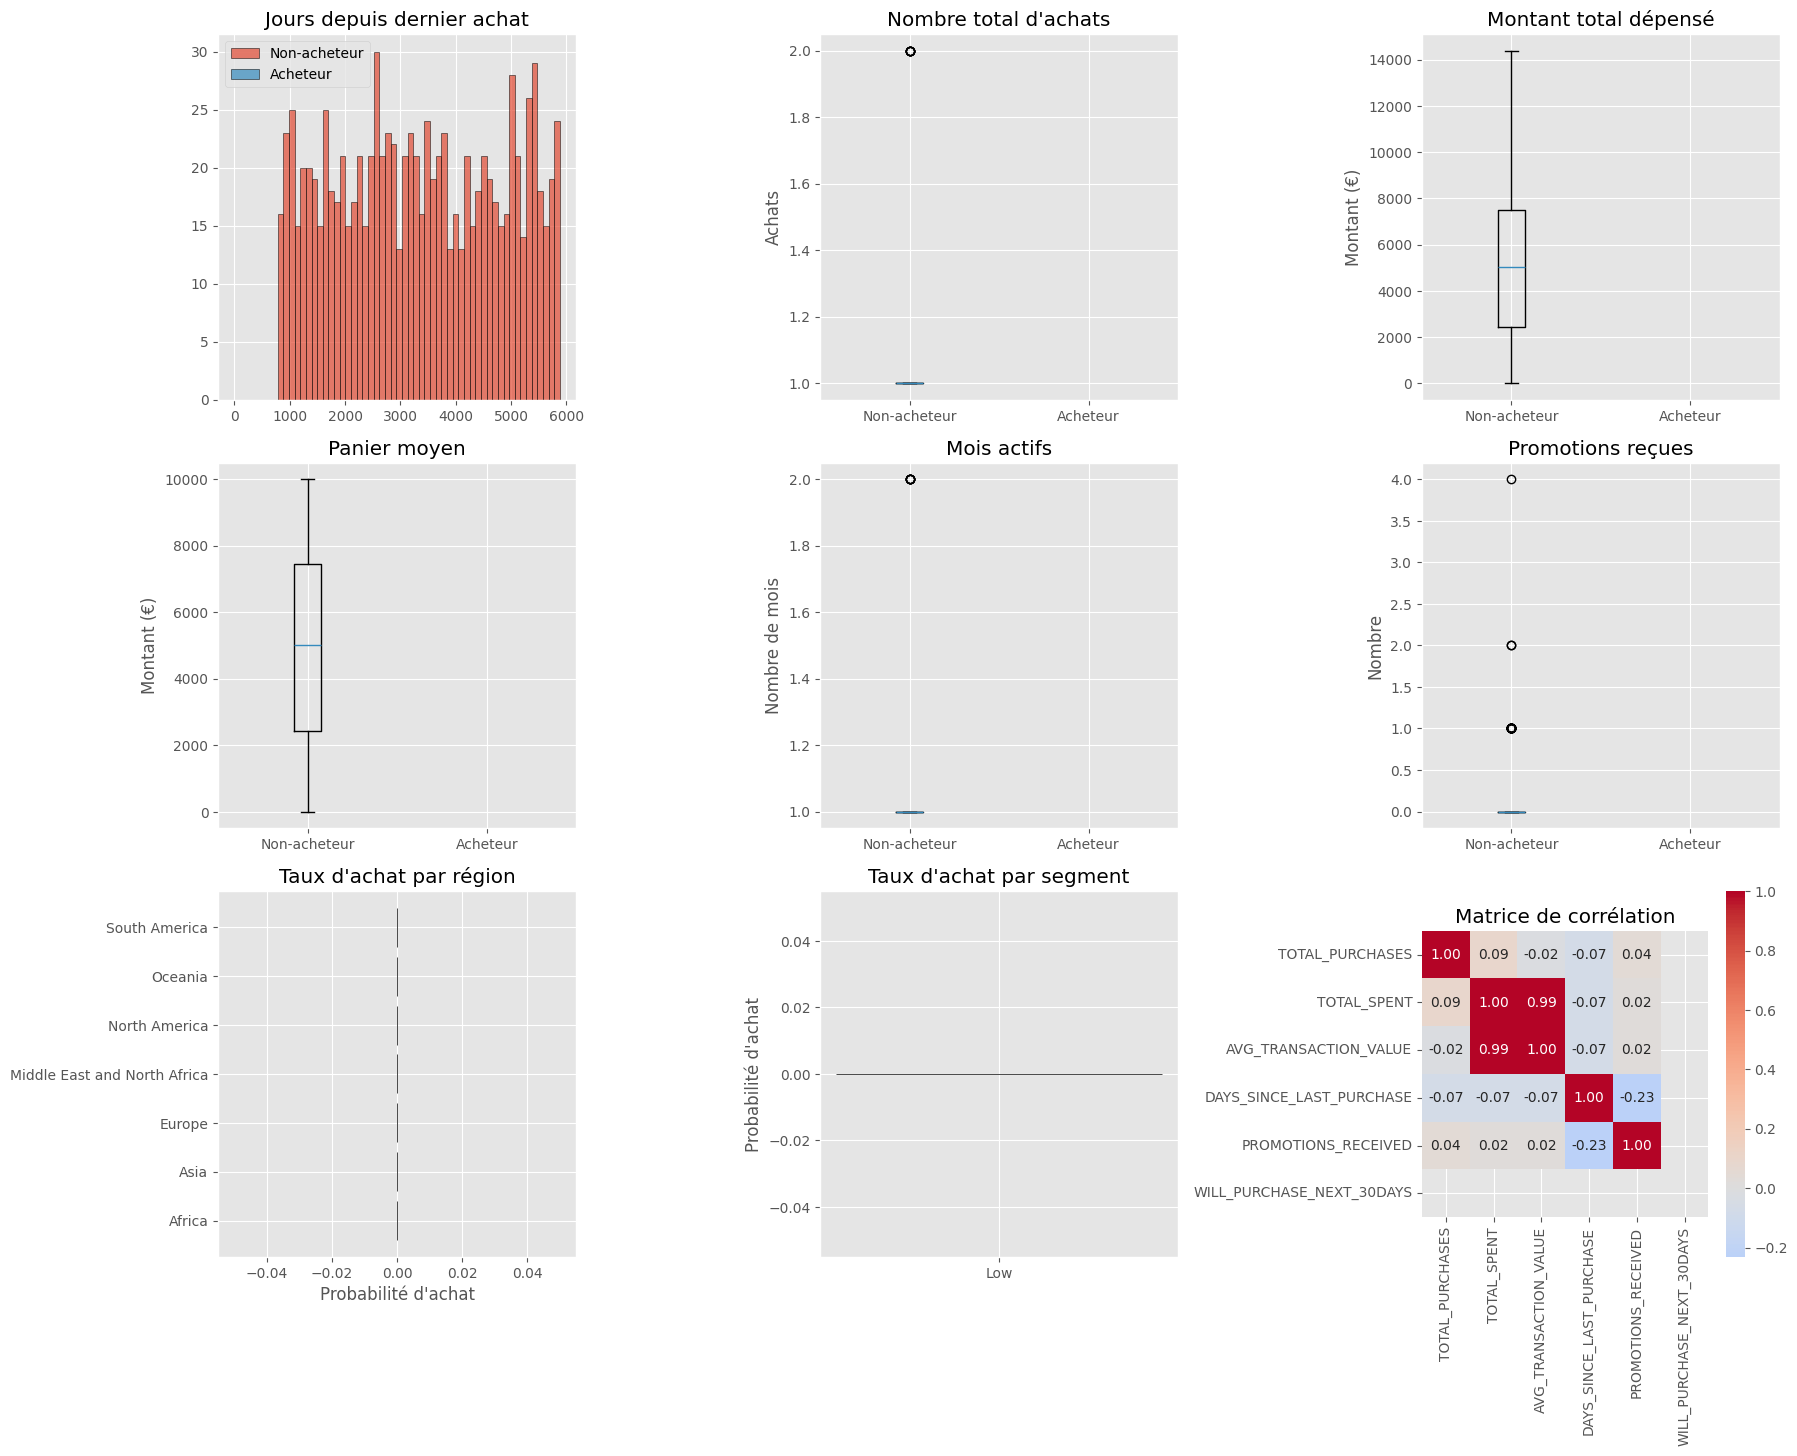

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 1. Distribution jours depuis dernier achat
axes[0, 0].hist(df[df['WILL_PURCHASE_NEXT_30DAYS']==0]['DAYS_SINCE_LAST_PURCHASE'], 
                bins=50, alpha=0.7, label='Non-acheteur', edgecolor='black')
axes[0, 0].hist(df[df['WILL_PURCHASE_NEXT_30DAYS']==1]['DAYS_SINCE_LAST_PURCHASE'], 
                bins=50, alpha=0.7, label='Acheteur', edgecolor='black')
axes[0, 0].set_title('Jours depuis dernier achat')
axes[0, 0].legend()

# 2. Total achats
axes[0, 1].boxplot([
    df[df['WILL_PURCHASE_NEXT_30DAYS']==0]['TOTAL_PURCHASES'],
    df[df['WILL_PURCHASE_NEXT_30DAYS']==1]['TOTAL_PURCHASES']
], labels=['Non-acheteur', 'Acheteur'])
axes[0, 1].set_title('Nombre total d\'achats')
axes[0, 1].set_ylabel('Achats')

# 3. Montant dépensé
axes[0, 2].boxplot([
    df[df['WILL_PURCHASE_NEXT_30DAYS']==0]['TOTAL_SPENT'],
    df[df['WILL_PURCHASE_NEXT_30DAYS']==1]['TOTAL_SPENT']
], labels=['Non-acheteur', 'Acheteur'])
axes[0, 2].set_title('Montant total dépensé')
axes[0, 2].set_ylabel('Montant (€)')

# 4. Panier moyen
axes[1, 0].boxplot([
    df[df['WILL_PURCHASE_NEXT_30DAYS']==0]['AVG_TRANSACTION_VALUE'],
    df[df['WILL_PURCHASE_NEXT_30DAYS']==1]['AVG_TRANSACTION_VALUE']
], labels=['Non-acheteur', 'Acheteur'])
axes[1, 0].set_title('Panier moyen')
axes[1, 0].set_ylabel('Montant (€)')

# 5. Mois actifs
axes[1, 1].boxplot([
    df[df['WILL_PURCHASE_NEXT_30DAYS']==0]['ACTIVE_MONTHS'],
    df[df['WILL_PURCHASE_NEXT_30DAYS']==1]['ACTIVE_MONTHS']
], labels=['Non-acheteur', 'Acheteur'])
axes[1, 1].set_title('Mois actifs')
axes[1, 1].set_ylabel('Nombre de mois')

# 6. Promotions reçues
axes[1, 2].boxplot([
    df[df['WILL_PURCHASE_NEXT_30DAYS']==0]['PROMOTIONS_RECEIVED'],
    df[df['WILL_PURCHASE_NEXT_30DAYS']==1]['PROMOTIONS_RECEIVED']
], labels=['Non-acheteur', 'Acheteur'])
axes[1, 2].set_title('Promotions reçues')
axes[1, 2].set_ylabel('Nombre')

# 7. Taux par région
region_rates = df.groupby('REGION')['WILL_PURCHASE_NEXT_30DAYS'].mean().sort_values(ascending=False)
axes[2, 0].barh(range(len(region_rates)), region_rates.values, edgecolor='black')
axes[2, 0].set_yticks(range(len(region_rates)))
axes[2, 0].set_yticklabels(region_rates.index)
axes[2, 0].set_title('Taux d\'achat par région')
axes[2, 0].set_xlabel('Probabilité d\'achat')

# 8. Taux par segment
segment_rates = df.groupby('PROPENSITY_SEGMENT')['WILL_PURCHASE_NEXT_30DAYS'].mean().sort_values(ascending=False)
axes[2, 1].bar(range(len(segment_rates)), segment_rates.values, edgecolor='black', color='coral')
axes[2, 1].set_xticks(range(len(segment_rates)))
axes[2, 1].set_xticklabels(segment_rates.index)
axes[2, 1].set_title('Taux d\'achat par segment')
axes[2, 1].set_ylabel('Probabilité d\'achat')

# 9. Matrice de corrélation
correlation_features = ['TOTAL_PURCHASES', 'TOTAL_SPENT', 'AVG_TRANSACTION_VALUE', 
                        'DAYS_SINCE_LAST_PURCHASE', 'PROMOTIONS_RECEIVED', 
                        'WILL_PURCHASE_NEXT_30DAYS']
corr_matrix = df[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[2, 2], square=True)
axes[2, 2].set_title('Matrice de corrélation')

plt.tight_layout()
plt.show()